# Installing Modules

In [ ]:
!pip install wandb -qU
!pip install pytorch_lightning


# Importing Modules


In [2]:
import wandb
import torch 
import pytorch_lightning as pl
import torch.nn as nn
from torch.nn  import functional
from pytorch_lightning.loggers import WandbLogger
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import random

# Downloading Unzip data

In [ ]:
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip


# Connecting Wandb


In [4]:

wandb.login(key="8d6c17aa48af2229c26cbc16513ef266358c0b96")
wandb.init(project="Assignment-02")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs22m076 (saisreeram). Use `wandb login --relogin` to force relogin


# Data Loading

In [5]:
baseDir = "inaturalist_12K"
trainDir = baseDir+"/train/"
testDir = baseDir+"/val/"
outputclasses=["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]
input_size = 256
batch_size = 16 


transform = transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

train_dataset = datasets.ImageFolder(root=baseDir+'/train',transform=transform)
test_dataset = datasets.ImageFolder(root=baseDir+'/val',transform=transform)
 
trainSize = int(0.8 * len(train_dataset))
valSize = len(train_dataset) - trainSize

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [trainSize, valSize])

train_dataset = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           )

val_dataset = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           )

test_dataset = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           )


# CNN model

In [6]:
class CNN(pl.LightningModule):
  def __init__(self,filters,activation,BatchNorm,dropout,learning_rate,input_size,kernel_size,pool_kernel_size,pool_stride):
    dense_size = input_size
    for i in filters:
      dense_size = (dense_size-kernel_size+1-pool_kernel_size)//pool_stride +1
    self.dense_size = dense_size
    super(CNN,self).__init__()
    self.train_step_acc = []
    self.train_step_loss = []
    self.val_step_acc = []
    self.val_step_loss = []

    self.learning_rate = learning_rate
    layers = []
    layers.append(nn.Conv2d(3,filters[0],kernel_size = kernel_size,stride = 1,padding = 0))
    layers.append(nn.MaxPool2d(kernel_size = pool_kernel_size,stride = pool_stride))
    layers.append(activation)
    for i in range(0,3):
      layers.append(nn.Conv2d(filters[i],filters[i+1],kernel_size = kernel_size,stride = 1,padding = 0))
      layers.append(nn.MaxPool2d(kernel_size = pool_kernel_size,stride = pool_stride))
      layers.append( activation)

    layers.append(nn.Conv2d(filters[3],filters[4],kernel_size = kernel_size,stride = 1,padding = 0))
    layers.append(nn.MaxPool2d(kernel_size = pool_kernel_size,stride = pool_stride))
    layers.append( activation)
    layers.append(nn.Flatten())
    
    if(BatchNorm == True):
      layers.append(nn.BatchNorm1d(filters[4]*self.dense_size*self.dense_size))
    layers.append(nn.Dropout(p=dropout))

    layers.append(nn.Linear(filters[4]*self.dense_size*self.dense_size,256 ))
    layers.append( activation)
    if(BatchNorm == True):
      layers.append(nn.BatchNorm1d(256))
    layers.append(nn.Dropout(p=dropout))
    layers.append(nn.Linear(256,10 ))

    self.layers = nn.Sequential(*layers)
        
    self.loss = nn.CrossEntropyLoss()

  def forward(self,x):
    return self.layers(x)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(),lr= self.learning_rate)

  def training_step(self,batch):
    trainX,trainY = batch
    output = self(trainX)
    loss = self.loss(output,trainY)
    acc = (output.argmax(dim = 1) == trainY).float().mean()
    self.train_step_acc.append(acc)
    self.train_step_loss.append(loss)

    self.log('train_loss1', loss,on_epoch = True,on_step = False,prog_bar=True,metric_attribute="train_loss")
    self.log('train_acc1', acc,on_epoch = True,on_step = False,prog_bar=True,metric_attribute="train_acc")
    return loss

  def on_train_epoch_end(self):
    
    train_acc =  torch.stack(self.train_step_acc).mean()
    train_loss =  torch.stack(self.train_step_loss).mean()
    val_acc =  torch.stack(self.val_step_acc).mean()
    val_loss =  torch.stack(self.val_step_loss).mean()

    # wandb.log({"train_loss":train_loss.item(),"train_acc":train_acc.item(),"val_loss":val_loss.item(),"val_acc":val_acc.item()})
    self.train_step_acc.clear() 
    self.train_step_loss.clear() 
    self.val_step_acc.clear() 
    self.val_step_loss.clear() 


  def validation_step(self, batch,batch_idx):
    trainX,trainY = batch
    output = self(trainX)
    loss = self.loss(output,trainY)
    acc = (output.argmax(dim = 1) == trainY).float().mean()
    self.val_step_acc.append(acc)
    self.val_step_loss.append(loss)
    self.log('val_loss1', loss,on_epoch = True,on_step = False,prog_bar=True,sync_dist=True)
    self.log('val_acc1', acc,on_epoch = True,on_step = False,prog_bar=True,sync_dist=True)
    return loss

  def test_step(self, batch,batch_idx):
    trainX,trainY = batch
    output = self(trainX)
    loss = self.loss(output,trainY)
    acc = (output.argmax(dim = 1) == trainY).float().mean()
    self.log('test_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.log('test_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    return loss

  def predict_step(self, batch,batch_idx,dataloader_idx=0):
    trainX = batch
    output = self(trainX)
    return output.argmax(dim = 1)

# Sweep Config

In [ ]:


config= {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_acc'
      },
    "parameters":
    {
    "filters":{
      "values" :[[64,64,64,64,64],[32,32,32,32,32],[4,8,16,32,64],[64,32,16,8,4]]
    },
    "data_augmentation" :{
        "values" : [True,False]
    },
    "batch_normalisation" :{
        "values" : [True,False]
    },
    "dropout" :{
        "values" : [0.2,0.3,0.4]
    },
    "activation" :{
          "values" : ["ReLU", "GELU", "SiLU", "Mish"]
    },
      "epochs" :{
          "values" : [5,  10]
    },
      "kernel_size" :{
          "values" : [3,4,5]
    },
      "pool_kernel_size" :{
          "values" : [2,  3]
    },

      "learning_rate" :{
          "values" : [1e-3,1e-4]
    }

    }

}


# Sweep Function

In [ ]:

activation_map = {"ReLU":nn.ReLU(), "GELU":nn.GELU(), "SiLU":nn.SiLU(), "Mish":nn.Mish()}
def sweeprun():

  wandb.init()
  filters = wandb.config.filters
  data_augmentation = wandb.config.data_augmentation
  batch_normalisation = wandb.config.batch_normalisation
  dropout = wandb.config.dropout
  activation = wandb.config.activation
  epochs = wandb.config.epochs
  learning_rate = wandb.config.learning_rate
  kernel_size = wandb.config.kernel_size
  pool_kernel_size = wandb.config.pool_kernel_size
  pool_stride = 2

  transform_aug = transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

  transform_basic = transforms.Compose([
              transforms.Resize((input_size,input_size)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
          ])

  train_dataset = datasets.ImageFolder(root=baseDir+'/train',
                                            transform=transform_basic)

  trainSize = int(0.8 * len(train_dataset))
  valSize = len(train_dataset) - trainSize

  train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [trainSize, valSize])
  if data_augmentation == True :
    train_dataset.transform = transform_aug
  train_dataset = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            )

  val_dataset = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            )

  run_name = "lr_{}_ac_{}_dp_{}_bn_{}_fi_{}_da_{}_ks_{}_pks_{}".format(learning_rate,activation, dropout, batch_normalisation,filters, data_augmentation,kernel_size,pool_kernel_size)

  activation = activation_map[activation]
  clf = CNN(filters,activation,batch_normalisation,dropout,learning_rate,input_size,kernel_size,pool_kernel_size,pool_stride) 
  trainer = pl.Trainer(max_epochs=epochs) 
  trainer.fit(clf,train_dataset,val_dataset)
  wandb.run.name = run_name
  wandb.finish()



sweep_id = wandb.sweep(config,project="Assignment-02-sweep", entity = "saisreeram")
wandb.agent(sweep_id, sweeprun)

# Best model on the test data

In [7]:
data_augmentation = True
transform_aug = transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
if data_augmentation == True :
    train_dataset.transform = transform_aug

clf = CNN([64,64,64,64,64],nn.GELU(),True,0.3,1e-4,input_size,3,3,2) 
trainer = pl.Trainer(max_epochs=5) #,accelerator='gpu'
trainer.fit(clf,train_dataset,val_dataset)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type             | Params
--------------------------------------------
0 | layers | Sequential       | 565 K 
1 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
565 K     Trainable params
0         Non-trainable params
565 K     Total params
2.263     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [8]:
trainer.test(clf, test_dataset)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.38999998569488525    │
│         test_loss         │    1.7644513845443726     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7644513845443726, 'test_acc': 0.38999998569488525}]

# Sample images from the test data and predictions

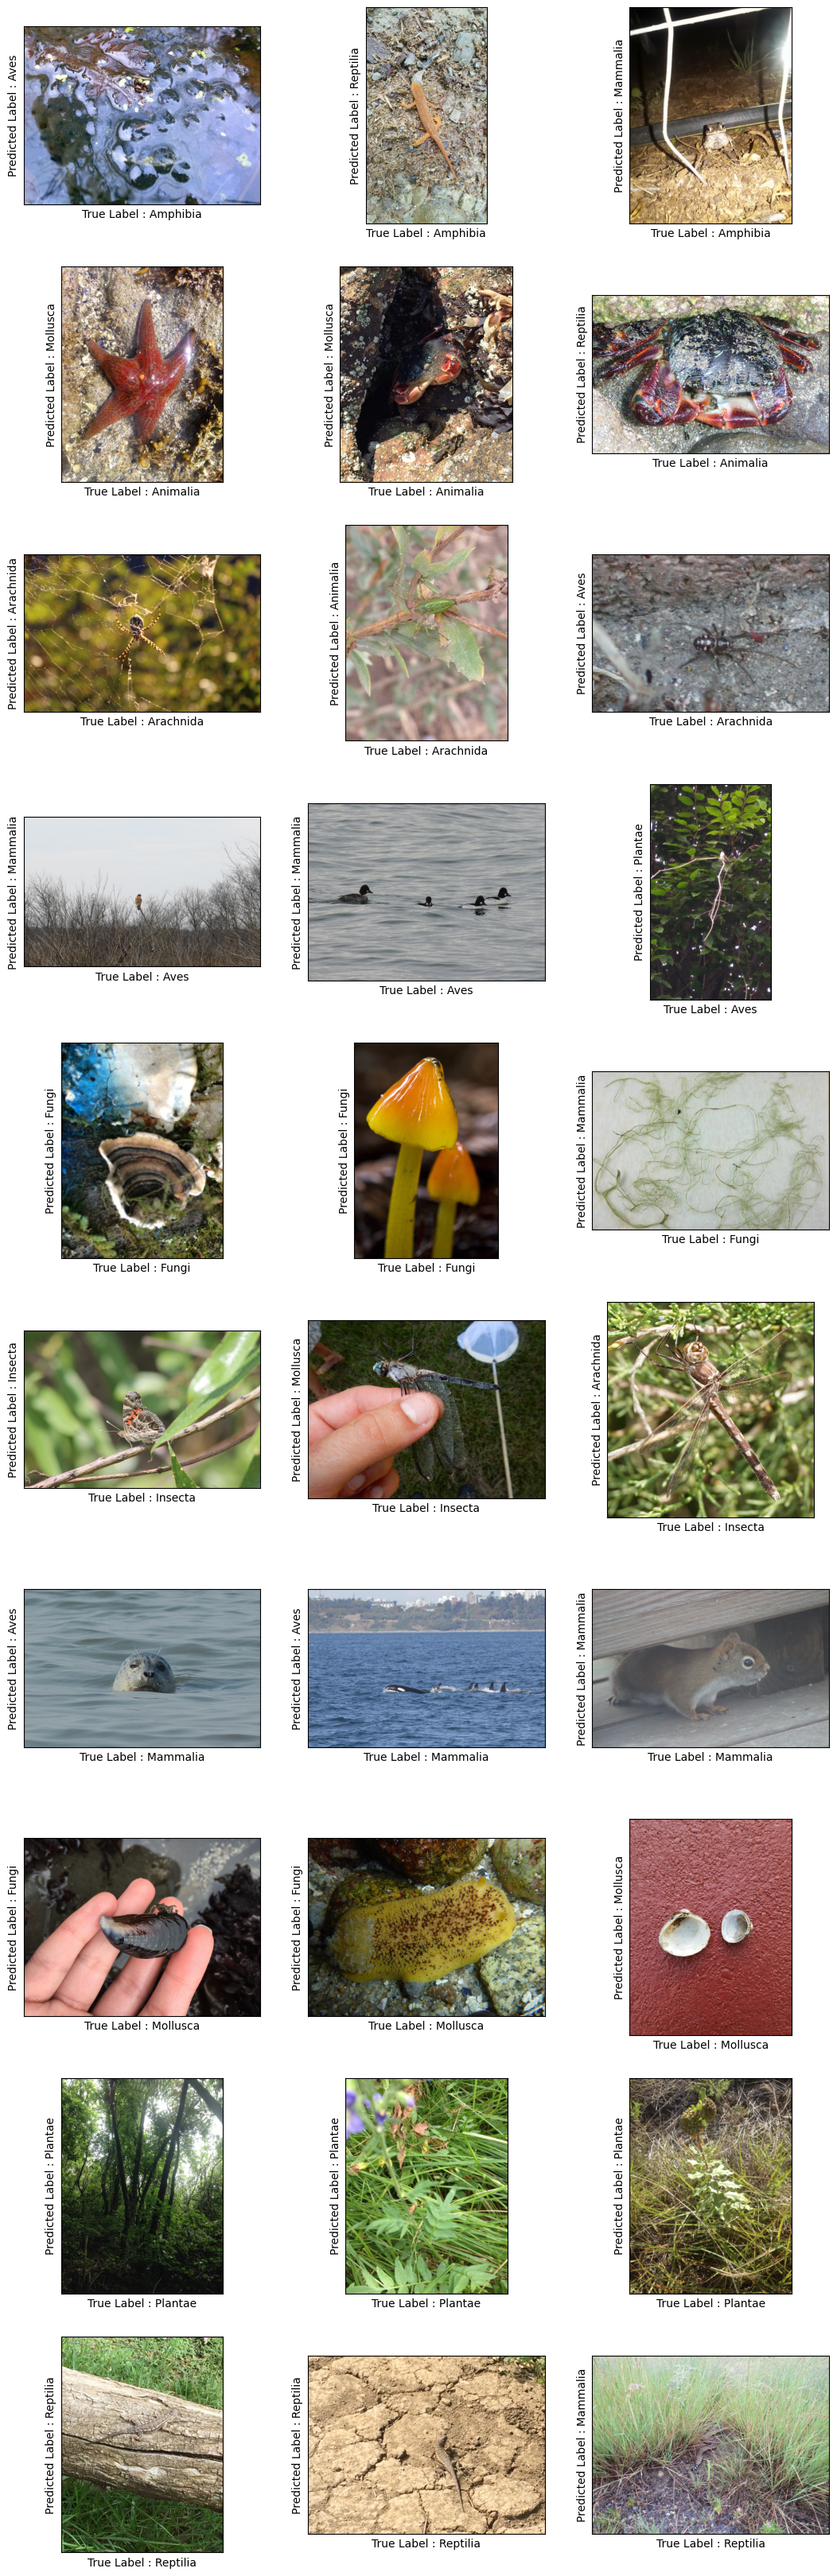

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

wanglog = []
transform = transforms.Compose([
              transforms.Resize((input_size,input_size)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
          ])

plt.figure(figsize=[15, 40])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in range(0,10):
  for j in range(0,3):
    plt.subplot(10,3,i*3+j+1)
    folder_path = "inaturalist_12K/train/"+outputclasses[i]
    files = os.listdir(folder_path)
    random_file = random.choice(files)
    image = Image.open(folder_path+'/'+random_file)
    image_tensor = transform(image)
    image_tensor = image_tensor.reshape(1,3,256,256)
    clf.eval()
    plt.xlabel('True Label : '+outputclasses[i])
    plt.ylabel('Predicted Label : '+outputclasses[clf.forward(image_tensor).argmax(dim = 1).item()])
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt.imshow(image)

wandb.log({"Question 4": wandb.Image(plt)})
